#### Pipeline:

1. Load and Prepare CSV Data
2. Load and Prepare not-annotated.json data
3. Concatenate and Train-Test Split
4. Bow and Logistic Regression with Hyperparam Search and 5 Fold CV
5. Test on test set
6. Test on annotated.json -> maybe with .predict_proba()

In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from preprocessing.preprocessing_csv import Preprocessing_CSV_Seniority
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from preprocessing.preprocessing_json import Preprocessing_JSON_annotated_Seniority
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import json
from imblearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Load and Prepare CSV Data
data = Preprocessing_CSV_Seniority(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/seniority-v2.csv"
)

X = data.X
y = data.y

In [3]:
# 2. Load and Prepare not-annotated.json Data
not_annotated_data = pd.read_csv("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/labeled_not_annotated.csv")
X_not_annotated = not_annotated_data["position"].astype(str).apply(data.clean_text)
y_not_annotated = not_annotated_data["seniority"].astype(str)

In [4]:
# 3. Concatenate and Train/Test split
X_concat = pd.concat([X, X_not_annotated], ignore_index=True)
y_concat = pd.concat([y, y_not_annotated], ignore_index=True)

ordinal_labels = ["Junior", "Professional", "Senior", "Lead", "Management", "Director"]
encoder = OrdinalEncoder(categories=[ordinal_labels], handle_unknown="use_encoded_value", unknown_value=-1)
y_encoded = encoder.fit_transform(y_concat.values.reshape(-1,1)).flatten()

print("Combined X:", X_concat.shape)
print("Combined y:", y_encoded.shape)
print("Unknown labels encoded as -1:", (y_encoded == -1).sum())
print(y_concat.value_counts())


Combined X: (9732,)
Combined y: (9732,)
Unknown labels encoded as -1: 0
Senior          3898
Lead            3547
Director         984
Management       815
Junior           476
Professional      12
Name: count, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_concat, y_encoded, test_size=0.2, stratify=y_encoded)

In [6]:
# 4. BOW and Logistic Regression with Hyperparam Search and 5 fold CV

bow = CountVectorizer(ngram_range=(1,2))
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

ros = RandomOverSampler(random_state=123)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_bow, y_train)

print(f"Original Shape: {X_train_bow.shape}\nBalanced Shape: {X_train_balanced.shape}")

Original Shape: (7785, 12756)
Balanced Shape: (18708, 12756)


In [17]:
parameters = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["liblinear"],
    "class_weight": [None, "balanced"]
}

logistic_reg = LogisticRegression(max_iter=1000)

grid = GridSearchCV(
    estimator=logistic_reg,
    param_grid=parameters,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_balanced, y_train_balanced)
best_model = grid.best_estimator_

print(f"Best params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.9882483865701912


In [18]:
# 5. Test on test-set

csv_prediction = best_model.predict(X_test_bow) # Auch predict_proba() probieren
print("Accuracy:", accuracy_score(y_test, csv_prediction))
print(
    classification_report(
        y_test,
        csv_prediction,
        target_names=ordinal_labels)
)

Accuracy: 0.9599383667180277
              precision    recall  f1-score   support

      Junior       0.91      0.91      0.91        95
Professional       0.14      0.50      0.22         2
      Senior       0.99      0.95      0.97       780
        Lead       0.96      0.99      0.97       710
  Management       0.90      0.90      0.90       163
    Director       0.97      0.98      0.98       197

    accuracy                           0.96      1947
   macro avg       0.81      0.87      0.82      1947
weighted avg       0.96      0.96      0.96      1947



In [9]:
# 6. Test on annotated.json

annotated_json_data = Preprocessing_JSON_annotated_Seniority(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json",
)

X_annotated = annotated_json_data.X
y_annotated = annotated_json_data.y

y_annotated_encoded = encoder.transform(y_annotated.values.reshape(-1,1)).flatten()


X_annotated_bow = bow.transform(X_annotated)

[JSON] Loaded 457 samples from /Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json


In [10]:
predict_annotated = best_model.predict(X_annotated_bow)

print(f"Accuracy on annotated.json: {accuracy_score(y_annotated_encoded, predict_annotated)}")

print(
    classification_report(
        y_annotated_encoded,
        predict_annotated,
        target_names=ordinal_labels,
        zero_division=0
    )
)

Accuracy on annotated.json: 0.45295404814004375
              precision    recall  f1-score   support

      Junior       0.19      0.50      0.27        10
Professional       0.27      0.02      0.04       154
      Senior       0.23      0.82      0.36        39
        Lead       0.44      0.68      0.53        97
  Management       0.88      0.60      0.71       133
    Director       0.55      0.88      0.68        24

    accuracy                           0.45       457
   macro avg       0.43      0.58      0.43       457
weighted avg       0.49      0.45      0.41       457



In [12]:
cm = confusion_matrix(y_annotated_encoded, predict_annotated)
labels = encoder.categories[0]

df_cm = pd.DataFrame(cm, index=labels, columns=labels)
print(df_cm)


              Junior  Professional  Senior  Lead  Management  Director
Junior             5             0       2     3           0         0
Professional      20             3      62    62           7         0
Senior             0             0      32     6           0         1
Lead               1             0      26    66           4         0
Management         1             8      16    12          80        16
Director           0             0       2     1           0        21


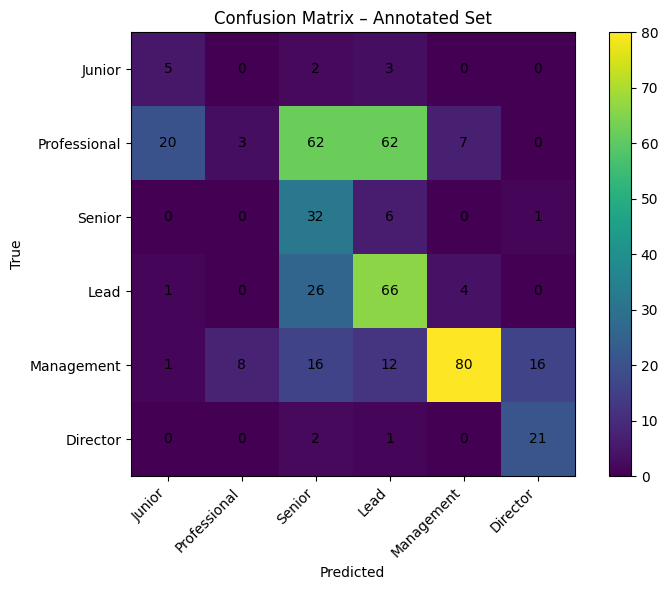

In [20]:
plt.figure(figsize=(8, 6))
plt.imshow(cm)

plt.title("Confusion Matrix – Annotated Set")
plt.colorbar()

plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
plt.yticks(np.arange(len(labels)), labels)

plt.xlabel("Predicted")
plt.ylabel("True")

# write numbers into cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()
